# User Study on Interpretability - Main Sections

### Description:
    
Throughout this study we will be using a dataset on online news. Each instance in this dataset is online news article from the site mashable.com, characterized by 53 features describing its length, contents, polarity and some metadata. We will provide short descriptions of each feature below. The task is to predict the *channel* ('world', 'tech', 'entertainment', 'business', 'social media' or 'lifestyle') in which each news article was published. 

The data consists of 33,510 examples, of which we use 80% for training and 20% for testing. The code below is a typical pipeline consiting of data loading and description, model training and validation.

After the model is trained, the interpretabilty tool will be instantatied and used to explain the predictions of this model.

### Instructions:

* Please read carefully and execute all cells. At the end of each section you will find a some questions, which you can answer in the empty cells provided below them.
* If you have any questions, please let the researcher now.
* Feel free to refer to the tutorial if you need a reminder of any of the concepts introduced there.


## Preliminaries: Data, Features, Meta-Features & Models

In [23]:
import sys
import importlib
import numpy as np
import pandas as pd
sys.path.append('../')

The target variable is the 'channel', which has 6 classes, distributed as shown here:

In [26]:
from src.data import load_online_news
X, Y, df, feature_groups, feature_desc = load_online_news(target='channel', transform='log')

Class           Examples
world            8427
tech             7346
entertainment    7057
bus              6258
socmed           2323
lifestyle        2099
Name: channel, dtype: int64


This dataset has 53 features, which could be hard to analyze simultaenously. Fortunately, there's many variables that encode similar aspects of the input, like length or polarity. There are 12 farily natural feature groups:

In [27]:
for i,idxs in enumerate(feature_groups.idxs):
    print('\nFeatue Group {}: {}'.format(i, feature_groups.names[i].upper()))
    for j in idxs:
        print('    {:30}\t->\t{}'.format(X.names[j], feature_desc[X.names[j]]))


Featue Group 0: LENGTH
    n_tokens_title                	->	Number of words in the title
    n_tokens_content              	->	Number of words in the content
    n_unique_tokens               	->	Rate of unique words in the content
    n_non_stop_words              	->	Rate of non-stop words in the content
    n_non_stop_unique_tokens      	->	Rate of unique non-stop words in the content
    average_token_length          	->	Average length of the words in the content

Featue Group 1: LINKS
    num_hrefs                     	->	Number of links
    num_self_hrefs                	->	Number of links to other articles published by Mashable
    self_reference_min_shares     	->	Min. shares of referenced articles in Mashable
    self_reference_max_shares     	->	Max. shares of referenced articles in Mashable
    self_reference_avg_sharess    	->	Avg. shares of referenced articles in Mashable

Featue Group 2: MEDIA
    num_imgs                      	->	Number of images
    num_videos        

We next show basic statistics of each feature:

In [138]:
pd.set_option('precision', 2)
df_desc = df.describe().transpose().merge(
    pd.DataFrame.from_dict(feature_groups.mapping, orient='index', columns=['feature group']), 
    left_index = True, right_index = True,
)
df_desc.sort_values(by='feature group')

,count,mean,std,min,25%,50%,75%,max,feature group
weekday_is_thursday,26808.0,0.18,3.88e-01,0.00e+00,0.00e+00,0.00e+00,0.00,1.00e+00,day
is_weekend,26808.0,0.13,3.32e-01,0.00e+00,0.00e+00,0.00e+00,0.00,1.00e+00,day
weekday_is_sunday,26808.0,0.07,2.47e-01,0.00e+00,0.00e+00,0.00e+00,0.00,1.00e+00,day
weekday_is_saturday,26808.0,0.06,2.39e-01,0.00e+00,0.00e+00,0.00e+00,0.00,1.00e+00,day
weekday_is_friday,26808.0,0.14,3.50e-01,0.00e+00,0.00e+00,0.00e+00,0.00,1.00e+00,day
weekday_is_wednesday,26808.0,0.19,3.93e-01,0.00e+00,0.00e+00,0.00e+00,0.00,1.00e+00,day
weekday_is_tuesday,26808.0,0.19,3.89e-01,0.00e+00,0.00e+00,0.00e+00,0.00,1.00e+00,day
weekday_is_monday,26808.0,0.17,3.76e-01,0.00e+00,0.00e+00,0.00e+00,0.00,1.00e+00,day
kw_max_max,26808.0,13.37,9.26e-01,1.00e-03,1.36e+01,1.36e+01,13.65,1.36e+01,keywords
kw_min_max,26808.0,4.88,4.49e+00,1.00e-03,1.00e-03,7.17e+00,8.82,1.36e+01,keywords


##### Model Training

We will train a classifier on this data.

In [6]:
import src.classifiers
classifier = src.classifiers.factory(dataset='online_news', model_type=2)
classifier.fit(X.train, Y.train)
print('Accuracy on train: {:4.2f}%'.format(100*classifier.score(X.train, Y.train)))
print('Accuracy on test: {:4.2f}%'.format(100*classifier.score(X.test, Y.test)))

Accuracy on train: 100.00%
Accuracy on test: 83.12%


## PART 1

##### Insantiate Explainers

We now create a Weight of Evidence estimator, and an explainer wrapper around it.

In [528]:
import importlib
import src.explainers, src.woe_new, src.utils
importlib.reload(src.explainers)
importlib.reload(src.woe_new)
importlib.reload(src.utils)

from src.utils import range_plot
from src.explainers import WOE_Explainer
from src.woe_new import woe_gaussian

woe_estimator =  woe_gaussian(classifier, X.train, classes = range(len(Y.names)), cond_type='nb')

woeexplainer = WOE_Explainer(classifier, woe_estimator,
                          classes=Y.names, features=X.names,
                          X=X.train, Y=Y.train,
                          featgroup_idxs = feature_groups.idxs,
                          featgroup_names = feature_groups.names)


Before explaining specific examples, let's look at the model's prior class probabilities.


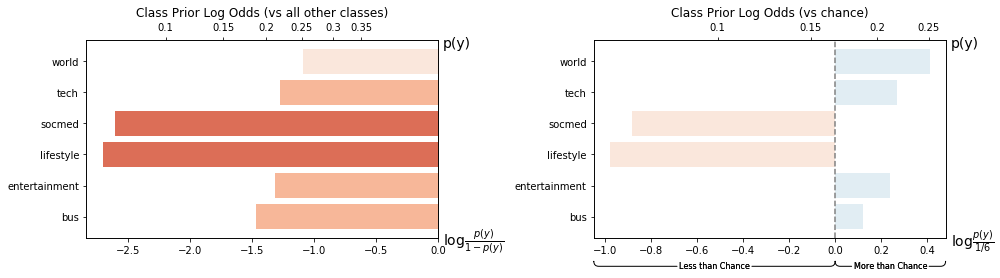

In [529]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
woeexplainer.plot_priors(normalize = None, ax = ax[0]) 
woeexplainer.plot_priors(normalize = 'chance', ax = ax[1]) 
plt.tight_layout()
plt.show()

The first plot shows that the prior log-odds of all classes are negative, because none of them has prior probability $>0.5$. This is the quantity that appears in the WoE predictive rule (Eq 1. in the tutorial).

While all of these are negative, their relative order matters: the second plot (now computed with respect to random chance, 1/6) is useful for quickly visualizing which classes are more likely than the others a priori.

Reminder: even .. 


##### Let's pick an example from the test set:

In [539]:
# idxs: 15, 32, 66
idx = 4 # Don't change this

and see what the model predicts:

In [530]:
pred_class = classifier.predict(X.test[idx].reshape(1,-1))[0]
pred_proba = classifier.predict_proba(X.test[idx].reshape(1,-1))[0][pred_class]

print(f"Predicted class: {Y.names[pred_class]} (prob: {pred_proba})")
print(f"True class:      {Y.names[Y.test[idx]]}")

Predicted class: world (prob: 0.97)
True class:      world


We look at this example's feature values compared to the aggregated training data:

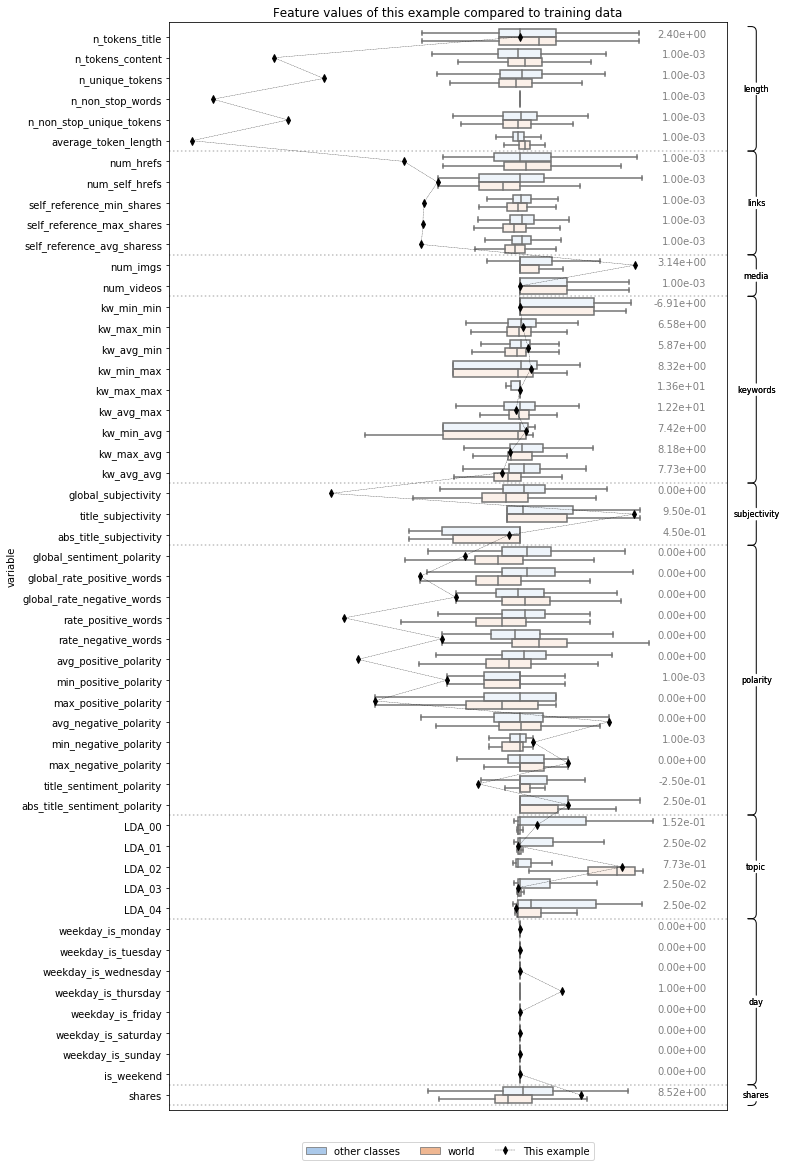

In [531]:
woeexplainer.plot_ranges(X.test[idx:idx+1], groupby='predicted', annotate='value', rescale=True)
plt.show()

The values of the all the features have been centered in this plot to facilitate visualization. While the absolute values of the features are not too important, the position of the black dots (the example being explained) with respect to the training data provides is useful to understand how this instance relates other examples.

Now explain the model's prediction for this example, using the Explainer tool.

Example index: 0
Prediction: world (p=0.97)
True class: world
Bayes odds explanation:

      14.82     =           -1.09  +  15.91   
post. log-odds  =  prior log-odds  +  total_woe

Total WoE in favor of 'world':    15.91



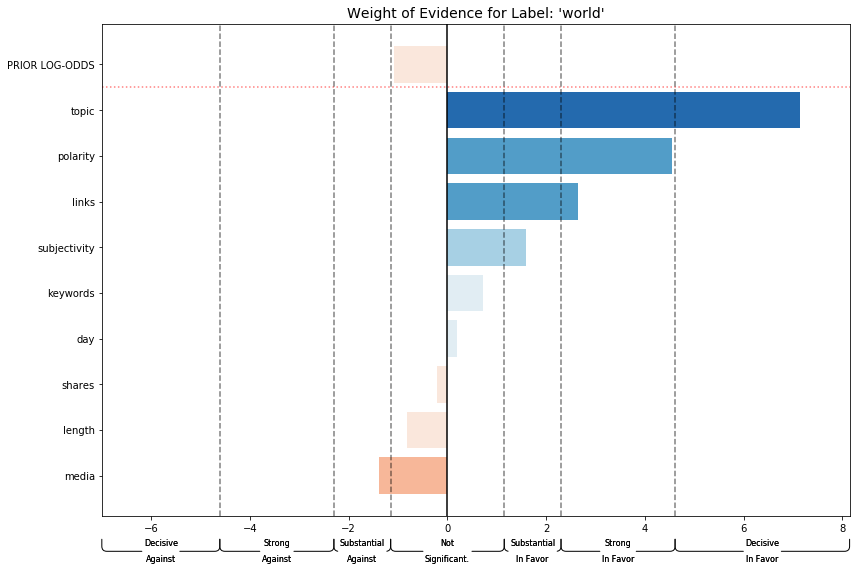

In [500]:
explanation_units = 'feature_groups' # -> can choose between 'features' or 'feature_groups'

e = woeexplainer.explain(X.test[idx:idx+1],
                         Y.test[idx:idx+1],
                         favor_class = 'predicted',
                         units=explanation_units,       
                         totext=False,
                         show_ranges=False,
                         sequential=False)

##### Q1: What aspect of the news article is the model relying on the most to make its prediction here?

Answer:

#### We will now take a look at a different example.

Example index: 0
Prediction: entertainment (p=0.68)
True class: entertainment
Bayes odds explanation:

      -0.57     =           -1.32  +  0.75    
post. log-odds  =  prior log-odds  +  total_woe

Total WoE in favor of 'entertainment':     0.75



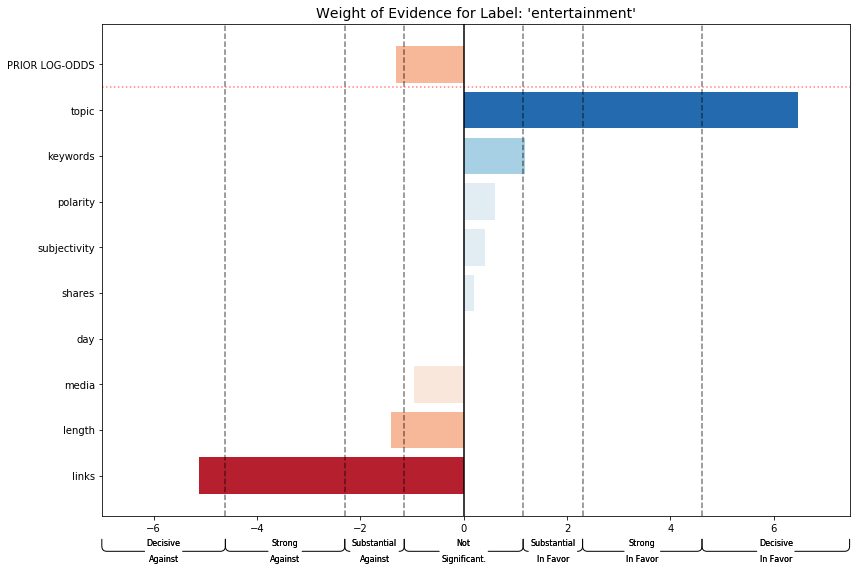

In [142]:
idx = 20

explanation_units = 'feature_groups' # -> one of 'features' or 'feature_groups'

e = woeexplainer.explain(X.test[idx:idx+1],
                         Y.test[idx:idx+1],
                         favor_class = 'predicted',
                         units=explanation_units,       
                         totext=False,
                         show_ranges=False,
                         sequential=False)

##### Q2: The model is not too confident (p=0.68) that this news article belongs to the 'entertainment' class. Why do you think that is? How would you change the article to cause the model to be more confident?

Answer:

## Part 2

For the second part of the study, we will continue working with the same dataset and model, but will now try to answer a different set of questions.

Let's pick another example:

In [549]:
idx = 5 # Don't change this.

and see what the model predicts in this case:

In [550]:
pred_class = classifier.predict(X.test[idx].reshape(1,-1))[0]
pred_proba = classifier.predict_proba(X.test[idx].reshape(1,-1))[0][pred_class]

print(f"Predicted class: {Y.names[pred_class]} (prob: {pred_proba})")
print(f"True class:      {Y.names[Y.test[idx]]}")

Predicted class: world (prob: 0.83)
True class:      tech


Example index: 0

--------------------
Explanation step:  1
Optimal score: 6.656522527925667
Contrasting hypotheses: [3, 4, 5]/[0, 1, 2]
Prediction: world (p=0.83)
True class: tech
Bayes odds explanation:

       7.31     =            0.15  +  7.16    
post. log-odds  =  prior log-odds  +  total_woe

Total WoE in favor of 'socmed','tech','world' (against 'bus','entertainment','lifestyle'):     7.16



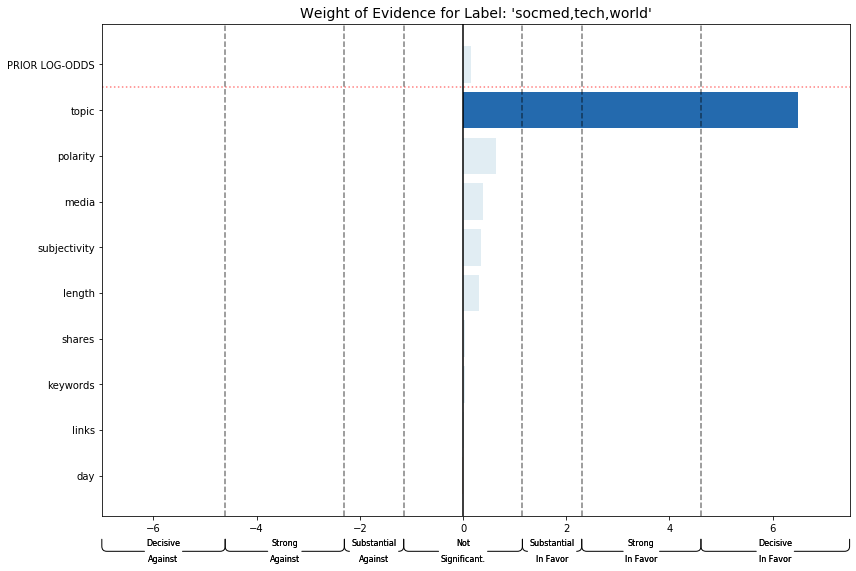


--------------------
Explanation step:  2
Optimal score: 5.091190548890893
Contrasting hypotheses: [5]/[3, 4]
Prediction: world (p=0.83)
True class: tech
Bayes odds explanation:

       5.96     =           -0.13  +  6.09    
post. log-odds  =  prior log-odds  +  total_woe

Total WoE in favor of 'world' (against 'socmed','tech'):     6.09



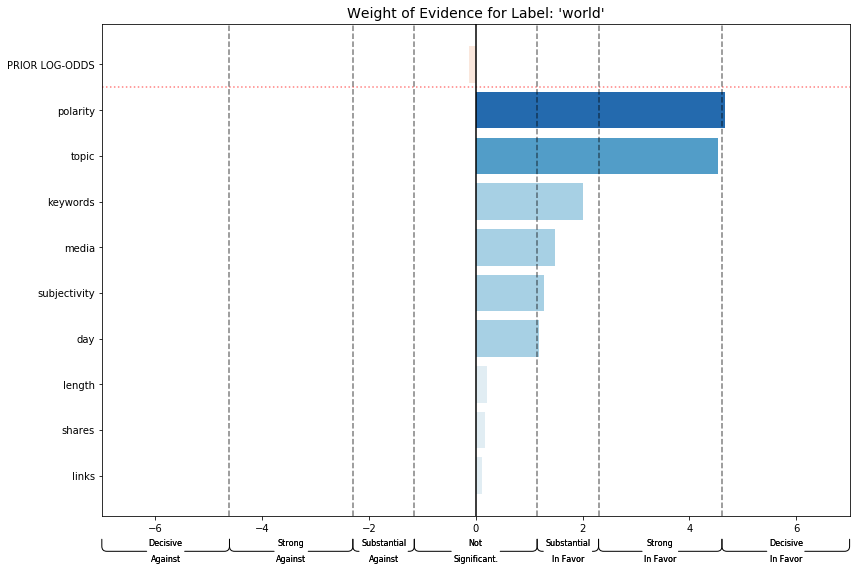

In [553]:
sequential_explanation = True # Choose True or False

e = woeexplainer.explain(X.test[idx:idx+1],
                         Y.test[idx:idx+1],
                         favor_class = 'predicted',
                         units='feature_groups',
                         totext=False,
                         show_ranges=False,
                         sequential=sequential_explanation)

##### Q3: Why do you think the model didn't predict 'business' instead?

Answer:

##### Q4: Why do you think the model didn't predict 'social media' instead?

Answer:

##### Q5: For other news articles that have similar keywords to this one, how much more likely do you think it is that the model with predict `world` instead of other classes?

Answer: 

## Follow-Up Questions

The researcher will now ask you a few general follow-up questions. 